In [2]:
from helpers.dataset import CreateTensorflowDataset
# https://stackoverflow.com/questions/66805180/how-to-get-iou-of-single-class-in-keras-semantic-segmentation
# Creates the dataset not upscaled
data_path = '/workspaces/Satelite/data'
upscaled = False
list_of_cantons = ['AG', 'ZH', 'BE']
loader = CreateTensorflowDataset(data_path, list_of_cantons, upscaled)

Preparing the dataset...


2024-05-20 20:04:08.927854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [893]
	 [[{{node Placeholder/_1}}]]
2024-05-20 20:04:21.859219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [111]
	 [[{{node Placeholder/_1}}]]
2024-05-20 20:04:23.543664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [113]
	

Done preparing the dataset.


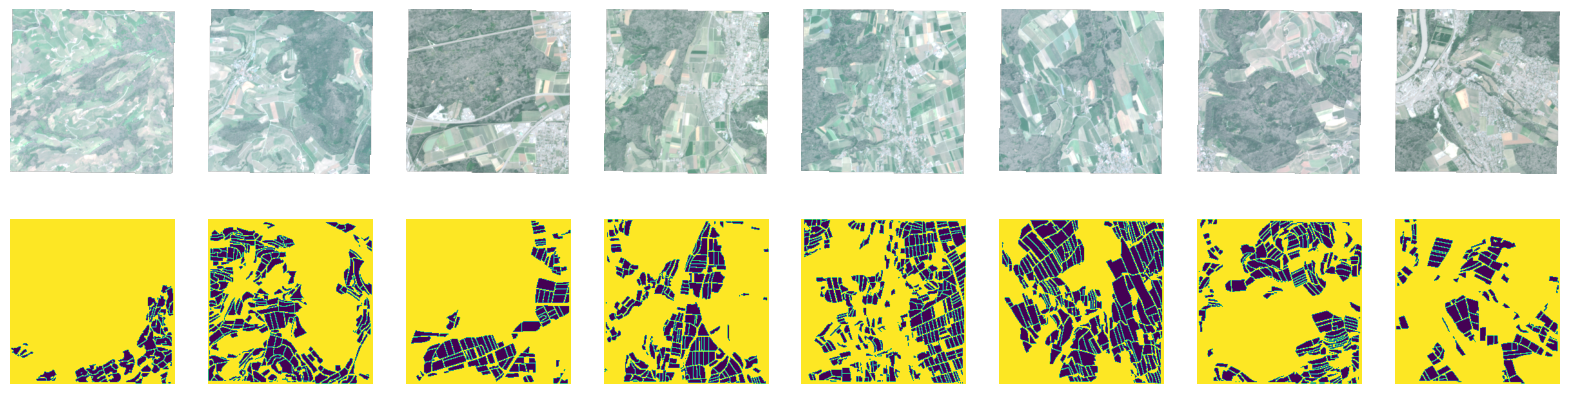

In [7]:
# Plot the images and masks
def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i])
        ax[1, i].axis('off')
    plt.show()
    
# Load the images and masks
for images, masks in val_data.dataset.take(1):
    plot_images(images, masks)
    
# Load the images and masks


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryIoU

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from helpers.RESUNETs import AttentionUNet
from helpers.load import LoadandAugment

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders
train_data = LoadandAugment(train_path, "train", 16, False)
val_data = LoadandAugment(val_path, "val", 16, False)


# Initialize UNET model
unet = AttentionUNet(input_shape=(256, 256, 4))
unet.model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])


# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
unet.model.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=100, 
    callbacks=[checkpoint_callback]
)


Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.6809
Epoch 1: val_loss improved from inf to 0.78705, saving model to best_model.h5
56/56 [==============================] - 24s 253ms/step - loss: 0.5849 - accuracy: 0.6809 - val_loss: 0.7871 - val_accuracy: 0.4017
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.7137
Epoch 2: val_loss improved from 0.78705 to 0.76589, saving model to best_model.h5
56/56 [==============================] - 13s 240ms/step - loss: 0.5479 - accuracy: 0.7137 - val_loss: 0.7659 - val_accuracy: 0.4150
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7220
Epoch 3: val_loss improved from 0.76589 to 0.64232, saving model to best_model.h5
56/56 [==============================] - 13s 240ms/step - loss: 0.5382 - accuracy: 0.7220 - val_loss: 0.6423 - val_accuracy: 0.6302
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.5302 -

KeyboardInterrupt: 

1/1 [==============================] - 1s 810ms/step
Min prediction value: 1.0
Max prediction value: 1.0


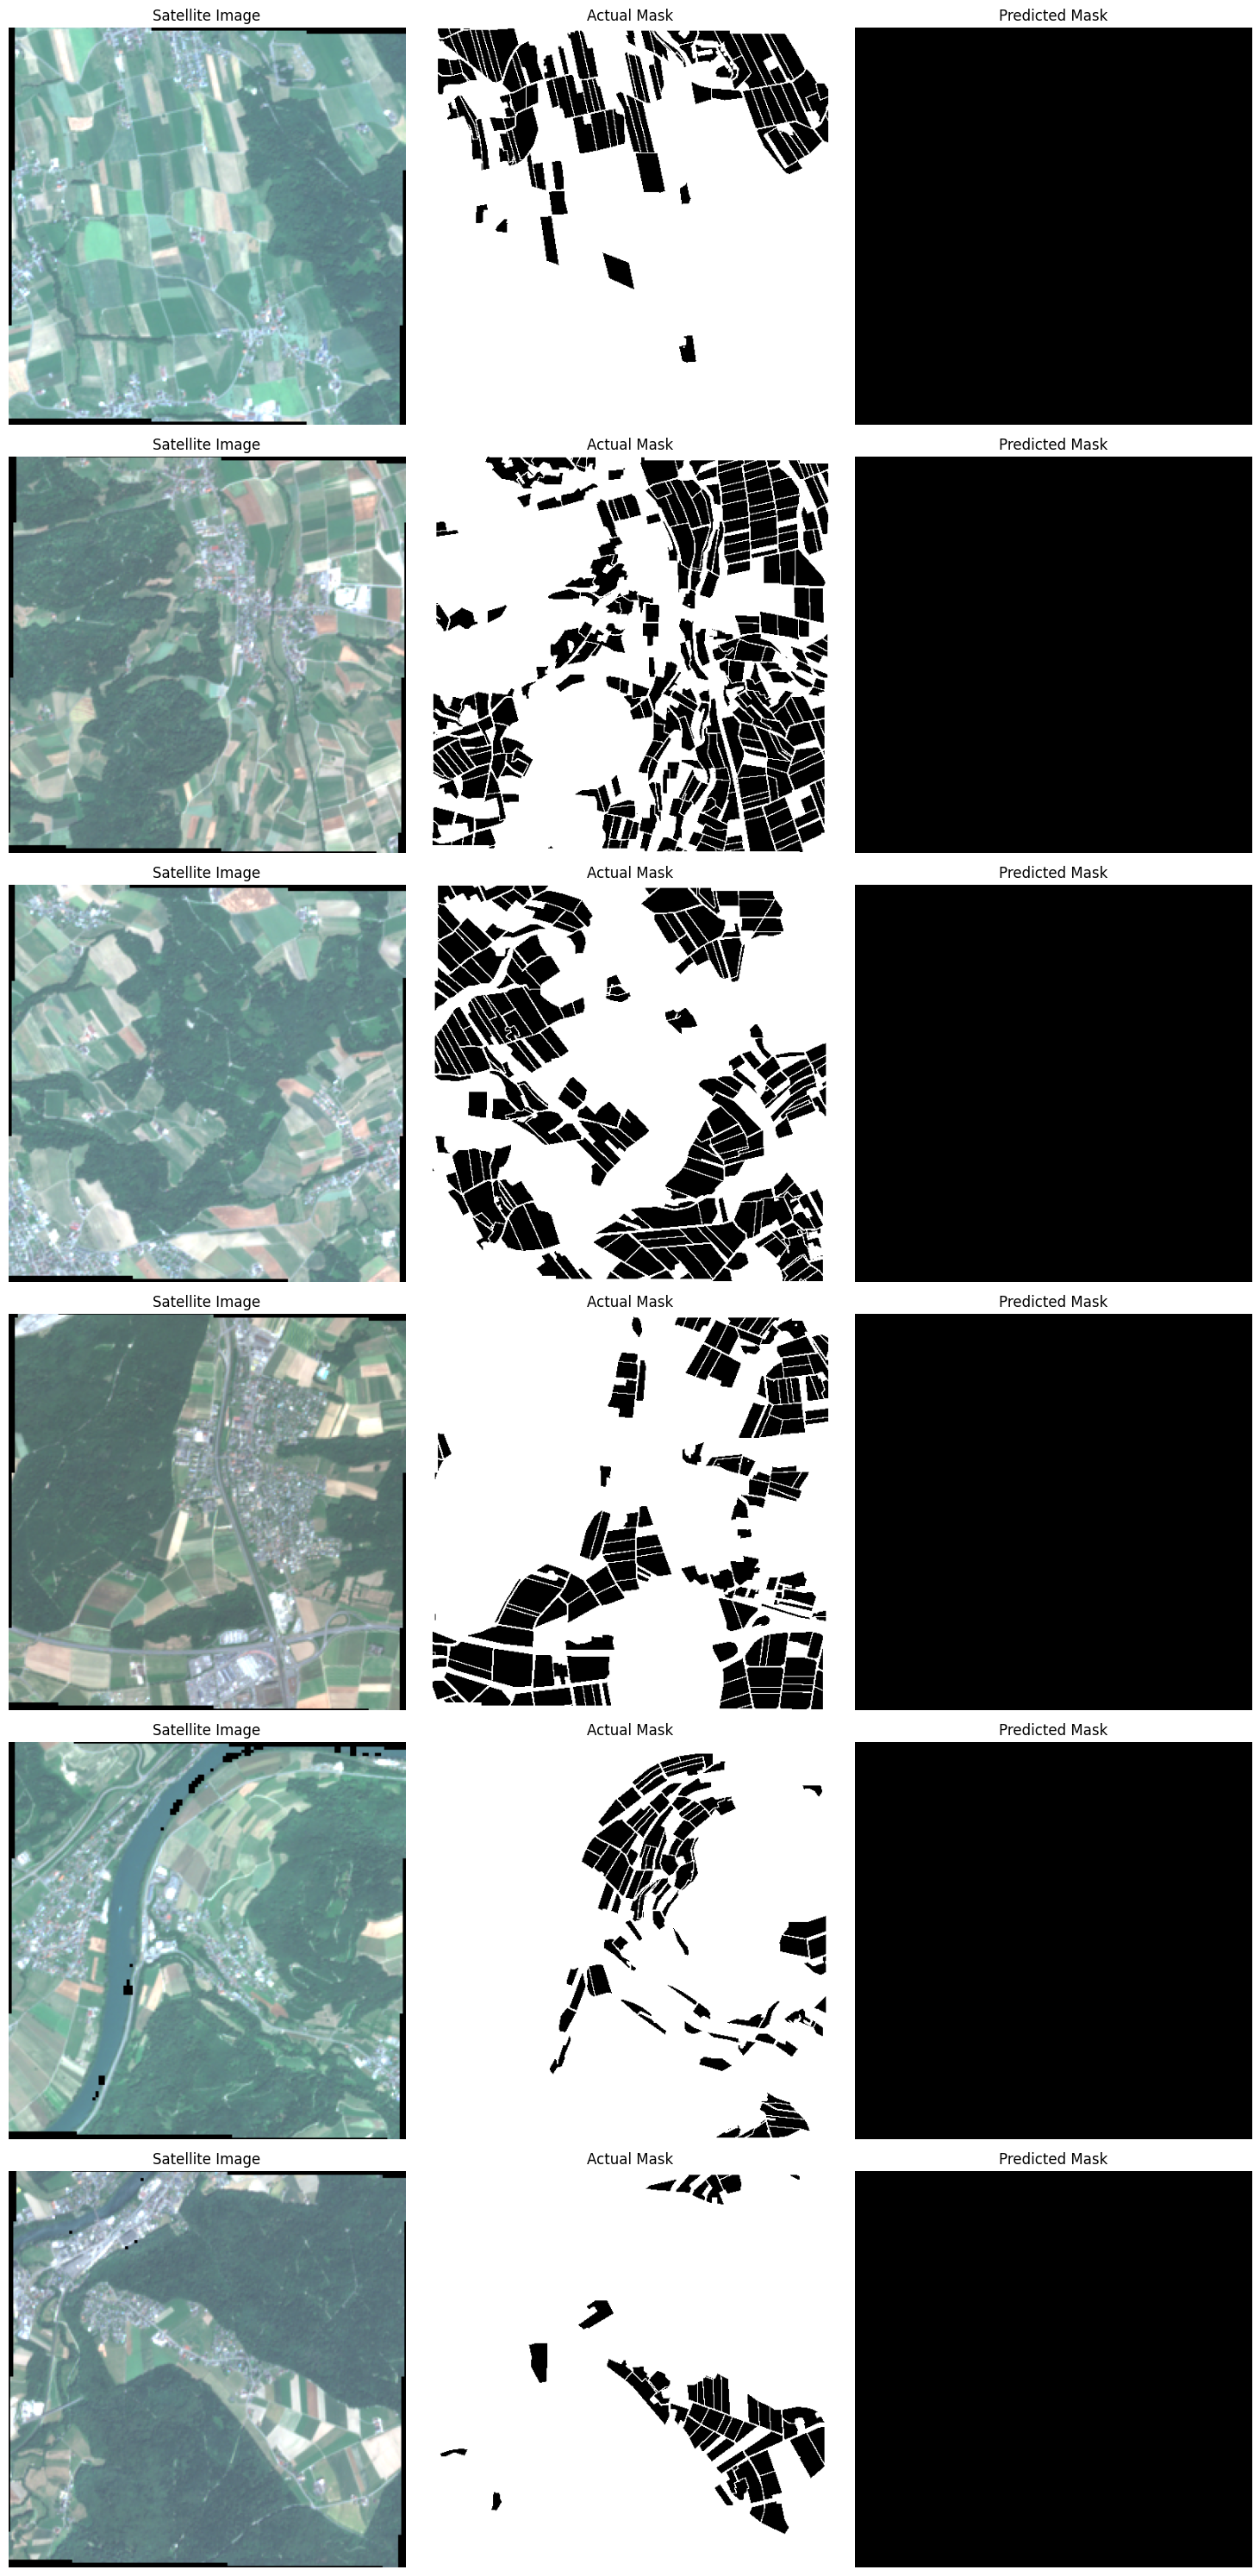

In [11]:

import numpy as np
from helpers.RESUnet import AttentionUNet
import matplotlib.pyplot as plt
from helpers.load import LoadandAugment
import os 

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
test_path = os.path.join(path, "test")

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the best model
unet.model.load_weights('best_model.h5')

# Evaluate the model
test_data = LoadandAugment(test_path, "test", 10, True)

# Predict on the test data
for images, masks in test_data.dataset:
    break
predictions = model.predict(images)
predictions = (predictions > 0.5).astype(np.float32) 

# Check predictions
print("Min prediction value:", predictions.min())
print("Max prediction value:", predictions.max())

# Plot the predictions
plot_predictions(images.numpy(), masks, predictions)
